In [1]:
!pip install ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, Dense, Flatten, LayerNormalization, MultiHeadAttention, Dropout, Input
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D


from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.regularizers import l2


from tensorflow.keras import regularizers

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping

import ta as ta
from ta import add_all_ta_features
from ta.utils import dropna

import re

import matplotlib.pyplot as plt

# Data and Feature Engineering

In [2]:
df = pd.read_csv('project_data.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.index = df.index.strftime('%Y-%m-%d')
df.ffill(inplace=True)


# We keep USDJPY only

# String to search for in column names
string_to_find = ['JPY','Date']
# Filter columns based on the string
filtered_columns = [col for col in df.columns if any(x in col for x in string_to_find)]
df.reset_index(inplace=True)

<ipython-input-2-dc2e7158d236>:2: UserWarning: Parsing dates in %d %m %Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index)


In [3]:
# FEATURE ENGINEERING PERFORMED HERE

# List of base asset names
assets = [ "JPY=X"]


# Dictionary to store new features
feature_dict = {}

# lags to create
lags = [2,3,4,5,6,7,8,9,10,15,21]

# Feature Engineering Loop
for asset in assets:
    open_col, high_col, low_col, close_col = [f"{asset}_{x}" for x in ["Open", "High", "Low", "Close"]]

    if close_col in df.columns:
        # Calculate the percentage return
        df[f"{asset}_Pct_Return"] = df[close_col].pct_change()
        # Create lags
        for lag in lags:
          df[f"{asset}_Pct_Return_Lag_{lag}"] = df[f"{asset}_Pct_Return"].shift(lag)

        # Momentum Indicators
        feature_dict[f"{asset}_RSI"] = ta.momentum.RSIIndicator(df[close_col], window=14).rsi()
        feature_dict[f"{asset}_ROC"] = ta.momentum.ROCIndicator(df[close_col], window=10).roc()
        feature_dict[f"{asset}_CCI"] = ta.trend.CCIIndicator(df[high_col], df[low_col], df[close_col], window=20).cci()

        # Trend Indicators
        feature_dict[f"{asset}_SMA_10"] = ta.trend.SMAIndicator(df[close_col], window=10).sma_indicator()
        feature_dict[f"{asset}_EMA_10"] = ta.trend.EMAIndicator(df[close_col], window=10).ema_indicator()
        feature_dict[f"{asset}_MACD"] = ta.trend.MACD(df[close_col]).macd()

        # Volatility Indicators
        bb = ta.volatility.BollingerBands(df[close_col])
        feature_dict[f"{asset}_BB_High"] = bb.bollinger_hband()
        feature_dict[f"{asset}_BB_Low"] = bb.bollinger_lband()
        feature_dict[f"{asset}_ATR"] = ta.volatility.AverageTrueRange(df[high_col], df[low_col], df[close_col]).average_true_range()
        donchian = ta.volatility.DonchianChannel(df[high_col], df[low_col], df[close_col], window=20)
        feature_dict[f"{asset}_Donchian_High"] = donchian.donchian_channel_hband()
        feature_dict[f"{asset}_Donchian_Low"] = donchian.donchian_channel_lband()
        feature_dict[f"{asset}_Ulcer"] = ta.volatility.UlcerIndex(df[close_col], window=14).ulcer_index()

        # Market Cycle Indicators
        # Keltner Channels (Volatility + Trend Direction)
        keltner = ta.volatility.KeltnerChannel(df[high_col], df[low_col], df[close_col])
        feature_dict[f"{asset}_Keltner_High"] = keltner.keltner_channel_hband()
        feature_dict[f"{asset}_Keltner_Low"] = keltner.keltner_channel_lband()


        # Volume Indicator (if applicable)
        if f"{asset}_Volume" in df.columns:
           feature_dict[f"{asset}_OBV"] = ta.volume.OnBalanceVolumeIndicator(df[close_col], df[f"{asset}_Volume"]).on_balance_volume()
           feature_dict[f"{asset}_CMF"] = ta.volume.ChaikinMoneyFlowIndicator(df[high_col], df[low_col], df[close_col], df[f"{asset}_Volume"]).chaikin_money_flow()
           feature_dict[f"{asset}_MFI"] = ta.volume.MFIIndicator(df[high_col], df[low_col], df[close_col], df[f"{asset}_Volume"]).money_flow_index()
           feature_dict[f"{asset}_VPT"] = ta.volume.VolumePriceTrendIndicator(df[close_col], df[f"{asset}_Volume"]).volume_price_trend()



# Efficiently merge new features into DataFrame
df = pd.concat([df, pd.DataFrame(feature_dict)], axis=1)


In [4]:
# Create target variables (1,5,10 day forward binary classification)
for asset in [i for i in df.columns if 'Close' in i ]:
    for r in ['01','05', '10']:
        col_fwd = f'{asset}_r{r}_fwd'.replace('Close_','')
        col_class = f'{col_fwd}_class'
        df[col_fwd] = df[asset].shift(-int(r)) / df[asset] - 1
        df[col_class] = np.where(df[col_fwd].notna(), (df[col_fwd] > 0).astype(int), np.nan)


# Drop the continous (keep binary classification (1 or 0))
df.drop(columns=['JPY=X_r01_fwd','JPY=X_r05_fwd','JPY=X_r10_fwd'
                 ], inplace=True)

df.reset_index(inplace=True)

In [5]:
# reformat data

def reformat_data(df):
  # Define main assets
  assets = ["JPY=X"]

  # Define assets that have fwd_class
  fwd_class_assets = ["JPY=X"]

  # Create regex patterns
  feature_pattern = rf"^({'|'.join(re.escape(a) for a in assets)})(_([\w\d]+))?$"
  fwd_class_pattern = rf"^({'|'.join(re.escape(a) for a in fwd_class_assets)})_r\d+_fwd_class$"

  # Identify relevant columns (normal features + fwd_class)
  valid_columns = ['Date'] + [col for col in df.columns if re.match(feature_pattern, col) or re.match(fwd_class_pattern, col)]

  # Keep only relevant columns
  df_filtered = df[valid_columns]

  # Melt the dataframe
  df_melted = df_filtered.melt(id_vars=['Date'], var_name='Asset_Feature', value_name='Value')

  # Extract Asset and Feature separately
  df_melted[['Asset', 'Feature']] = df_melted['Asset_Feature'].str.extract(
      rf"^({'|'.join(re.escape(a) for a in assets)})(?:_([\w\d]+(?:_fwd_class)?))?$"
  )

  # Drop the old column
  df_melted.drop(columns=['Asset_Feature'], inplace=True)

  # Pivot to get a single row per Date + Asset
  df = df_melted.pivot_table(
      index=['Date', 'Asset'],
      columns='Feature',
      values='Value',
      aggfunc='first'
  ).reset_index()


  # drop 'Asset' since it is only on USDJPY
  df.drop(columns=['Asset'], inplace=True)

  return df

df = reformat_data(df)
df.dropna(inplace=True)
df.head()

Feature,Date,ATR,BB_High,BB_Low,CCI,Close,Donchian_High,Donchian_Low,EMA_10,High,...,Pct_Return_Lag_7,Pct_Return_Lag_8,Pct_Return_Lag_9,ROC,RSI,SMA_10,Ulcer,r01_fwd_class,r05_fwd_class,r10_fwd_class
25,2006-06-21,1.006049,116.069465,111.149534,72.633931,114.834999,115.739998,111.339996,114.565162,115.190002,...,0.003685,0.000219,0.004452,1.238648,66.015137,114.734499,0.343141,1.0,1.0,1.0
26,2006-06-22,1.048474,116.355589,111.295410,111.058933,116.080002,116.269997,111.339996,114.840587,116.269997,...,0.007519,0.003685,0.000219,1.882656,73.489541,114.948999,0.245804,1.0,0.0,0.0
27,2006-06-23,1.032868,116.748988,111.291011,133.464661,116.540001,116.580002,111.339996,115.149571,116.580002,...,-0.003297,0.007519,0.003685,2.263954,75.622812,115.206999,0.226777,0.0,0.0,0.0
28,2006-06-26,0.991235,117.005695,111.400304,120.115867,116.220001,116.580002,111.339996,115.344195,116.540001,...,-0.001262,-0.003297,0.007519,1.608676,71.323129,115.391000,0.238355,1.0,0.0,0.0
29,2006-06-27,0.978647,117.192613,111.630386,111.325919,116.320000,116.684998,111.339996,115.521614,116.684998,...,0.003705,-0.001262,-0.003297,0.937176,71.861539,115.499000,0.243636,1.0,0.0,0.0


# Data Preprocessing (specify target variable to use)

In [6]:
# Use only 1 target variable

# Specify the one you want to use
target_variable = 'r10_fwd_class'  # Change this line to switch targets


all_targets = ['r01_fwd_class', 'r05_fwd_class', 'r10_fwd_class']


# Remove the other target columns dynamically
remove_cols = [col for col in all_targets if col != target_variable]
df.drop(columns=remove_cols, inplace=True)

# Keep only rows with non-null target values
df = df[df[target_variable].notna()]
df.dropna(inplace=True)

df

Feature,Date,ATR,BB_High,BB_Low,CCI,Close,Donchian_High,Donchian_Low,EMA_10,High,...,Pct_Return_Lag_5,Pct_Return_Lag_6,Pct_Return_Lag_7,Pct_Return_Lag_8,Pct_Return_Lag_9,ROC,RSI,SMA_10,Ulcer,r10_fwd_class
25,2006-06-21,1.006049,116.069465,111.149534,72.633931,114.834999,115.739998,111.339996,114.565162,115.190002,...,-0.003297,0.007519,0.003685,0.000219,0.004452,1.238648,66.015137,114.734499,0.343141,1.0
26,2006-06-22,1.048474,116.355589,111.295410,111.058933,116.080002,116.269997,111.339996,114.840587,116.269997,...,-0.001262,-0.003297,0.007519,0.003685,0.000219,1.882656,73.489541,114.948999,0.245804,0.0
27,2006-06-23,1.032868,116.748988,111.291011,133.464661,116.540001,116.580002,111.339996,115.149571,116.580002,...,0.003705,-0.001262,-0.003297,0.007519,0.003685,2.263954,75.622812,115.206999,0.226777,0.0
28,2006-06-26,0.991235,117.005695,111.400304,120.115867,116.220001,116.580002,111.339996,115.344195,116.540001,...,0.002084,0.003705,-0.001262,-0.003297,0.007519,1.608676,71.323129,115.391000,0.238355,0.0
29,2006-06-27,0.978647,117.192613,111.630386,111.325919,116.320000,116.684998,111.339996,115.521614,116.684998,...,-0.004160,0.002084,0.003705,-0.001262,-0.003297,0.937176,71.861539,115.499000,0.243636,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,2024-12-10,1.706312,157.288139,148.249062,-38.184683,151.408005,156.746002,148.651001,151.057038,152.167007,...,-0.002602,-0.008441,-0.001070,-0.010934,-0.008868,-1.923850,48.280564,150.678400,3.022454,1.0
4845,2024-12-11,1.696718,157.077982,148.174420,-20.607441,151.807007,156.746002,148.651001,151.193396,152.770004,...,0.000930,-0.002602,-0.008441,-0.001070,-0.010934,-0.785572,50.364239,150.558200,3.048474,1.0
4846,2024-12-12,1.644167,156.730204,148.203798,-3.215887,152.244995,156.746002,148.651001,151.384596,152.768005,...,0.006148,0.000930,-0.002602,-0.008441,-0.001070,0.600648,52.620746,150.649100,3.046613,1.0
4847,2024-12-13,1.635727,156.123348,148.422554,30.881697,152.587006,155.871994,148.651001,151.603216,153.770996,...,-0.002391,0.006148,0.000930,-0.002602,-0.008441,0.934691,54.365356,150.790401,3.036558,1.0


In [7]:
# Perform minmax scaler on numerical variables
# min max scaler
scaler = MinMaxScaler()
# standard scalar
#scaler = StandardScaler()

df[df.columns[1:-1]] = scaler.fit_transform(df[df.columns[1:-1]])

df.head()

Feature,Date,ATR,BB_High,BB_Low,CCI,Close,Donchian_High,Donchian_Low,EMA_10,High,...,Pct_Return_Lag_5,Pct_Return_Lag_6,Pct_Return_Lag_7,Pct_Return_Lag_8,Pct_Return_Lag_9,ROC,RSI,SMA_10,Ulcer,r10_fwd_class
25,2006-06-21,0.178897,0.449183,0.438949,0.556554,0.455223,0.454593,0.437238,0.452397,0.456170,...,0.457143,0.489727,0.478179,0.467738,0.480489,0.618630,0.701449,0.452322,0.018049,1.0
26,2006-06-22,0.190712,0.452477,0.440715,0.598868,0.469720,0.460849,0.437238,0.455649,0.468733,...,0.463273,0.457143,0.489727,0.478179,0.467738,0.639929,0.805190,0.454850,0.012201,0.0
27,2006-06-23,0.186366,0.457005,0.440662,0.623542,0.475076,0.464509,0.437238,0.459298,0.472339,...,0.478238,0.463273,0.457143,0.489727,0.478179,0.652540,0.834799,0.457891,0.011058,0.0
28,2006-06-26,0.174772,0.459961,0.441985,0.608842,0.471350,0.464509,0.437238,0.461596,0.471873,...,0.473356,0.478238,0.463273,0.457143,0.489727,0.630868,0.775121,0.460059,0.011754,0.0
29,2006-06-27,0.171267,0.462112,0.444771,0.599162,0.472514,0.465748,0.437238,0.463692,0.473560,...,0.454544,0.473356,0.478238,0.463273,0.457143,0.608659,0.782594,0.461332,0.012071,0.0


In [8]:
drop_cols = [target_variable]
drop_cols += [col for col in ['Date', 'Asset'] if col in df.columns]
drop_cols

['r10_fwd_class', 'Date']

In [9]:
target_variable

'r10_fwd_class'

In [10]:
# Create 3d numpy array sequence to be fed into model


def create_sequence(df, drop_cols, sequence_length=500, target_variable=None):
    df = df.sort_values(['Date']).reset_index(drop=True)

    X, y = [], []

    for i in range(len(df) - sequence_length):
        seq_x = df.drop(columns=drop_cols).iloc[i:i+sequence_length].values
        seq_y = df[target_variable].iloc[i+sequence_length]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y).astype(np.float32)


X_seq, y_seq = create_sequence(df, drop_cols, sequence_length=500, target_variable=target_variable)

In [11]:
# Train-Val-Test Split

# First, split into train and temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.20)  # 80% train, 20% temp

# Then, split temp into val and test (e.g., 10% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50)  # Half of 20% = 10% each

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3459, 500, 30)
(432, 500, 30)
(433, 500, 30)
(3459,)
(432,)
(433,)


# CNN-Transformer Model Building

In [12]:
# set seed for reproducability
keras.utils.set_random_seed(456)


def CTTS(input_shape=(500, 30), num_classes=2, kernel_size=16, stride=8,
         embed_dim=128, num_heads=4, transformer_depth=3, drop_rate=0.3):
    """
    CNN-Transformer Time Series Model (CTTS) for classifying stock price movements (Up/Down).

    Args:
        input_shape: Shape of input time series (e.g., (window_size, 1)).
        num_classes: Number of output classes (2 for Up and Down).
        kernel_size: CNN kernel size (default=16).
        stride: CNN stride (default=8).
        embed_dim: Transformer embedding dimension (default=128).
        num_heads: Number of self-attention heads (default=4).
        transformer_depth: Number of Transformer encoder layers (default=4).
        drop_rate: Dropout rate (default=0.3).
    """
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # reg
    l2_reg = regularizers.l2(1e-4)

    # 1D CNN for local pattern extraction
    x = layers.Conv1D(
        filters=embed_dim,        # number of output feature maps
        kernel_size=kernel_size,  # slide over x time steps at a time
        strides=stride,           # move kernel by x step
        padding="same",           # keep output length = input length
        activation="relu",
        kernel_regularizer=l2_reg
    )(inputs)

    # Normalise token embeddings
    x = layers.BatchNormalization()(x)



    # Positional embedding
    seq_length = math.ceil(input_shape[0]/stride)
    positions = tf.range(start=0, limit=seq_length, delta=1)
    pos_embed = layers.Embedding(input_dim=seq_length, output_dim=embed_dim)(positions)
    x = x + pos_embed


    # Transformer Encoder
    for _ in range(transformer_depth):
        # Multi-Head Attention

        attn_input = x
        attn = layers.LayerNormalization()(attn_input)
        attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=drop_rate
        )(attn, attn)

        x = attn_input + attn # skip connection

        # Feed-Forward Network
        ffn_input = x
        ffn = layers.LayerNormalization()(ffn_input)
        ffn = layers.Dense(embed_dim, activation='relu')(ffn)
        ffn = layers.Dropout(drop_rate)(ffn)

        x = ffn_input + ffn # skip connection

    # Global Average Pooling and MLP Head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(drop_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=l2_reg)(x)

    return models.Model(inputs, outputs)

# Example usage

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

cw_dict = dict(zip(np.unique(y_train), class_weights))


model = CTTS(input_shape=(500, 30))
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500, 30)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 63, 128)   │     61,568 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 63, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 63, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 63, 128)   │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 63, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 63, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 63, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 63, 128)   │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 63, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 63, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 63, 128)   │          0 │ add_2[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 63, 128)   │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 63, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 63, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 63, 128)   │          0 │ add_3[0][0],      │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 63, 128)   │        256 │ add_4[0][0]     

 Total params: 912,897 (3.48 MB)

 Trainable params: 912,641 (3.48 MB)

 Non-trainable params: 256 (1.00 KB)

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping, lr_schedule],
    class_weight = cw_dict,
    verbose=1,
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 444ms/step - accuracy: 0.5086 - loss: 0.9233 - val_accuracy: 0.4931 - val_loss: 0.7092 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.5389 - loss: 0.7323 - val_accuracy: 0.4931 - val_loss: 0.8079 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5718 - loss: 0.7039 - val_accuracy: 0.5208 - val_loss: 0.7054 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5423 - loss: 0.7071 - val_accuracy: 0.5694 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5430 - loss: 0.7006 - val_accuracy: 0.5694 - val_loss: 0.7100 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5671 - loss: 0.7009 - val_accuracy: 0.5370 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5676 - loss: 0.6855

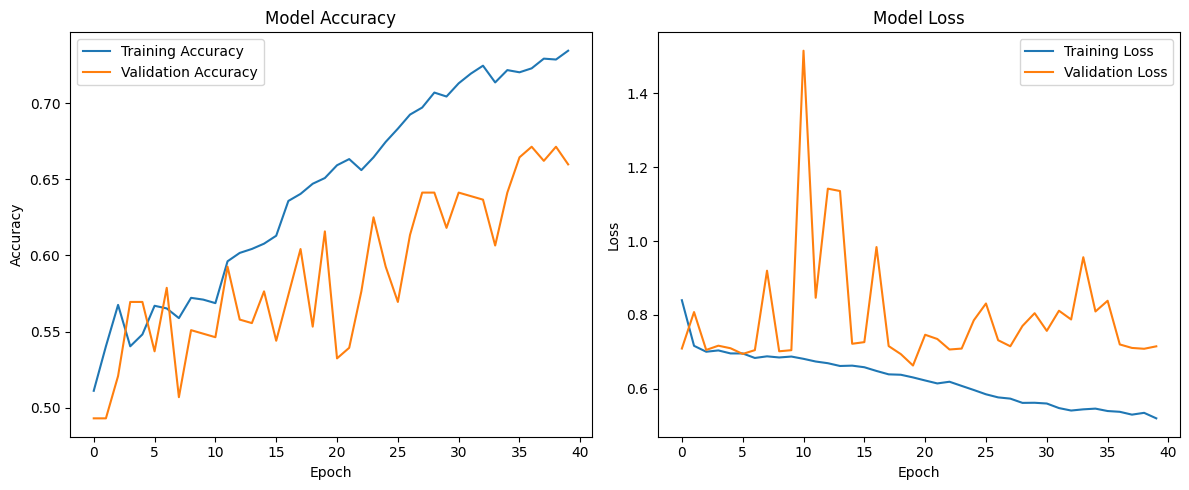

In [14]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
y_probs = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


In [16]:
# round probability to nearest 1 and 0
y_probs_rounded = np.round(y_probs)


# Apply thresholding (0 if ≤0.45, 1 if ≥0.55)
#y_probs_thresh = np.where(y_probs > 0.55, 1, np.where(y_probs < 0.45, 0, np.nan))

#mask = ~np.isnan(y_probs_thresh).flatten()
#y_probs_filtered = y_probs_thresh[mask]
#y_test_filtered = y_test[mask]

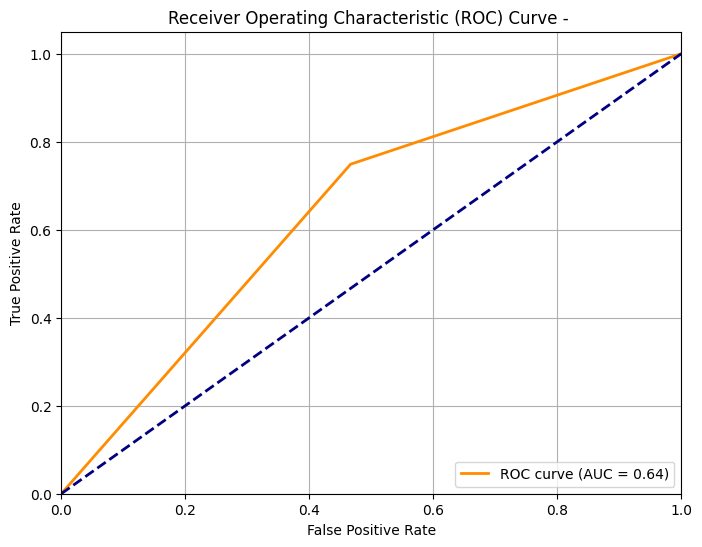

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_rounded)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - ')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [18]:
# Test Accuracy
accuracy = accuracy_score(y_test, y_probs_rounded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 64.43%
